In [31]:

from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import os

## astropy
import astropy.units as u
from astropy.table import Table

## ctapipe
from ctapipe_io_nectarcam import NectarCAMEventSource 
from ctapipe.io import event_source, EventSeeker

import scipy.stats as scst
from scipy.stats import poisson                                                                                                             

from fit_ses_v6 import *
#import seaborn as sns




In [2]:
plt.rcParams['figure.figsize'] = [15, 7]

In [3]:
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_200pe_newWF.simtel.gz'
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_200pe_newWF_1kev.simtel.gz'
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_200pe_WF1010_noise36_TTled.simtel.gz'
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_200pe_WF1010_noise36_TTled3ns.simtel.gz'
        MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_100pe_WF1010_noise36_TTled_SPE1812_NG.simtel.gz'


        
        inputfile_reader_MC = event_source(
            input_url = MC_file_path,
            max_events=1000)
        all_QMC = []
        all_wfs = []
        for ii, event in enumerate(inputfile_reader_MC):
            all_wfs.append(event.r0.tel[1].waveform[:,:])
            all_QMC.append(event.mc.tel[1].photo_electron_image)
        wfs_MC    = np.array(all_wfs)
        all_QMC   = np.array(all_QMC)
        ped_MC = event.mc.tel[1].pedestal/64

In [4]:
        data_file_path = "/media/ttaverni/Transcend/data/scans_08019/NectarCAM.Run1568.00[0-9][0-9].fits.fz"
        #data_file_path = "/media/ttaverni/Transcend/data/scans_08019/NectarCAM.Run1557.00[0-9][0-9].fits.fz"
        #data_file_path = "/media/ttaverni/Transcend/data/scans_08019/NectarCAM.Run1079.00[0-9][0-9].fits.fz"
        
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=500000)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id[:]
        all_wfs = []
        pedwfs = []
        AQ=[]
        for ii, event in enumerate(inputfile_reader):
            Qm = (event.r0.tel[event.r0.tels_with_data[0]].waveform[0,pix_ids,:]-250.).sum(axis=1).mean()/58.
            AQ.append(Qm)
            if ii <1000:
                pedwfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
            if Qm >150 and Qm<250:
                all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
                if len(all_wfs)>1000:
                    break
        wfs_data = np.array(all_wfs)
        pedwfs   = np.array(pedwfs).mean(axis=0)

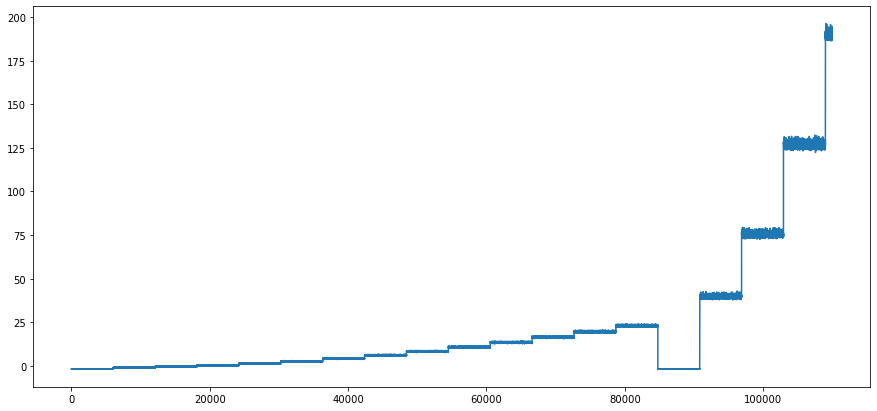

In [5]:
plt.plot(AQ)

In [123]:
ii -1000

108984

In [6]:
all_wfs=[]
wfs_MC.shape

(1000, 2, 1855, 64)

In [7]:
wfs_data.shape

(1001, 2, 427, 60)

In [8]:
maxs_MC = wfs_MC.argmax(axis=3).flatten()
maxs_data = wfs_data.argmax(axis=3).flatten()

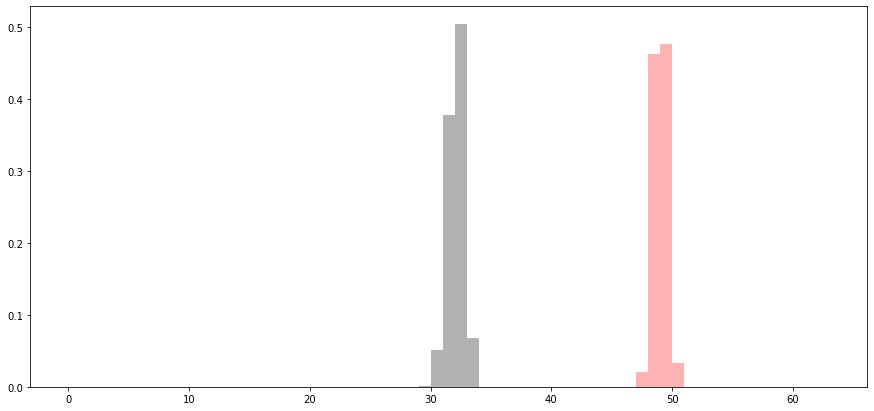

In [9]:
h = plt.hist(maxs_MC,  bins=np.arange(0,64),density=1,alpha=.3,color='red',label = 'MC')
h = plt.hist(maxs_data,bins=np.arange(0,64),density=1,alpha=.3,color='black',label='Data')

In [10]:
wfs_means_MC = wfs_MC[:,0].mean(axis=0)

wfs_means_data = wfs_data[:,0].mean(axis=0)

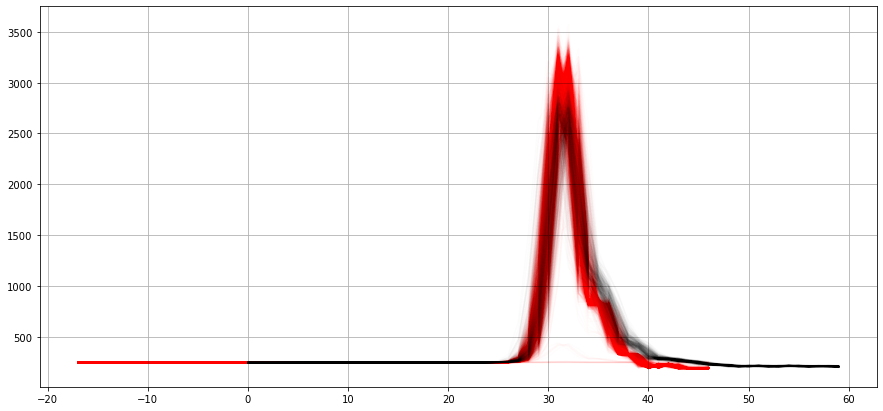

In [11]:


p = plt.plot(np.arange(0,64)-17,wfs_means_MC.T,alpha=.01,color='red',label = 'MC')
p = plt.plot(wfs_means_data.T,alpha=.01,color='black',label = 'data')
plt.gca().grid()

In [12]:
QMC_hg =  np.array([ (wfs_MC[:,0,ii,40:56].T-ped_MC[0,ii]).sum(axis=0)/58. for ii in range(1855) ]).T
QMC_lg =  np.array([ (wfs_MC[:,1,ii,40:56].T-ped_MC[1,ii]).sum(axis=0)/58. for ii in range(1855) ]).T
QMC_hg.shape

(1000, 1855)

In [13]:
Qdata_hg = (wfs_data[:,0,:,25:45]-pedwfs[0,:,25:45]).sum(axis=2)/58.
Qdata_lg = (wfs_data[:,1,:,25:45]-pedwfs[1,:,25:45]).sum(axis=2)/58.

In [14]:

geom = CameraGeometry.from_name("NectarCam")

Qs = QMC_hg.mean(axis=0)
Qs_data = Qdata_hg.mean(axis=0)



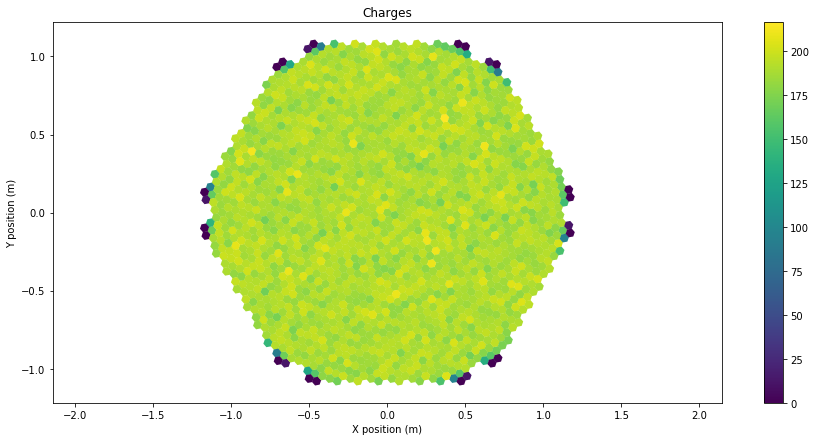

In [15]:
disp1 = CameraDisplay(geom,title='Charges')
disp1.add_colorbar()
disp1.image = Qs

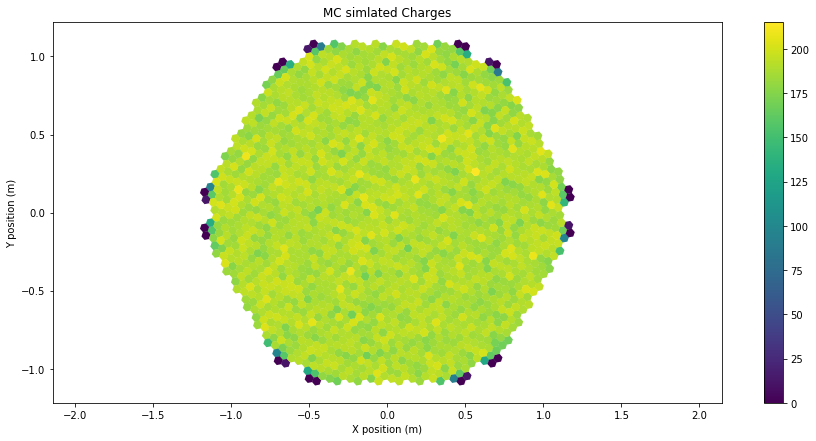

In [16]:
disp1 = CameraDisplay(geom,title='MC simlated Charges')
disp1.add_colorbar()
disp1.image = all_QMC.mean(axis=0)

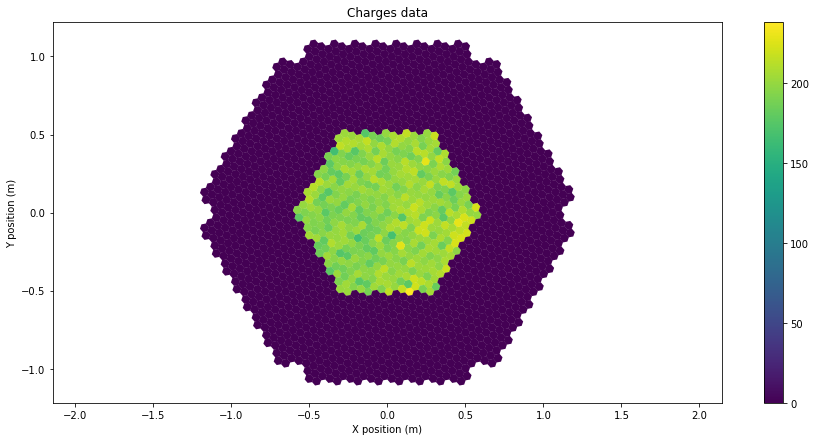

In [17]:
disp1 = CameraDisplay(CameraGeometry.from_name("NectarCam-003"),title='Charges data')
disp1.add_colorbar()
img = np.arange(1855)*0
img[pix_ids] = Qs_data
disp1.image = img

In [18]:
## cuting non illuminated pixels
mmask = all_QMC.mean(axis=0)>100

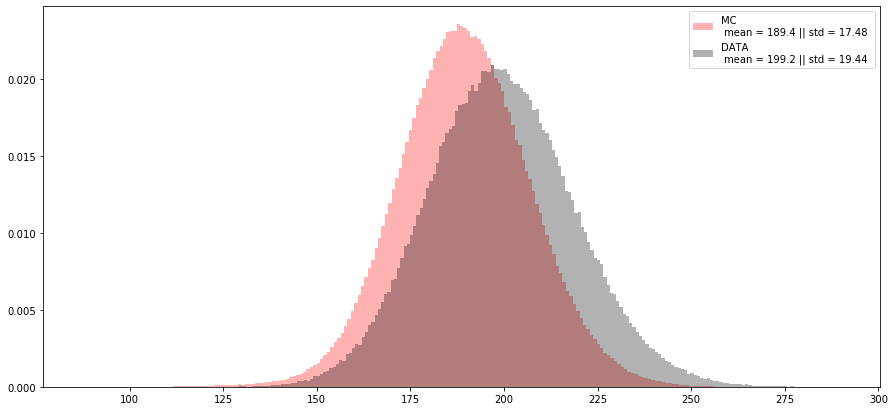

In [124]:
mmean = np.mean(QMC_hg[:,mmask])
mstd  = np.std(QMC_hg[:,mmask])

h = plt.hist(QMC_hg[:,mmask].flatten(),200,color = 'red',alpha=.3,\
             label= 'MC \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)


mmean = np.mean(Qdata_hg)
mstd  = np.std(Qdata_hg)
h = plt.hist(Qdata_hg.flatten(),200,color = 'black',alpha=.3,\
             label= 'DATA \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)
plt.gca().legend()

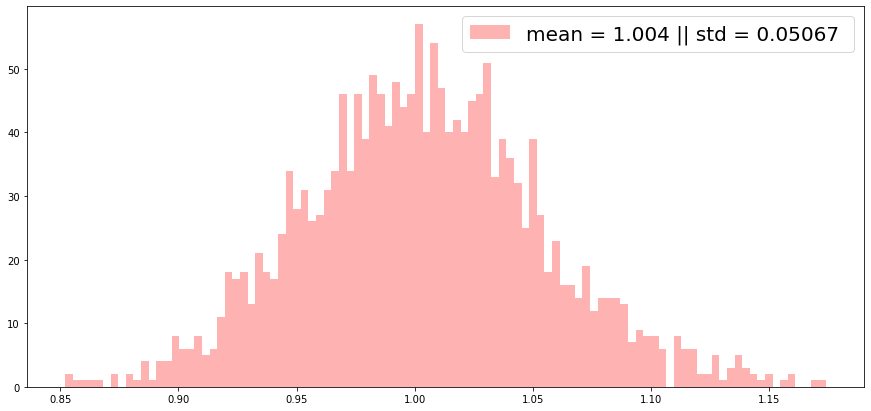

In [19]:

mmean = np.mean(Qs[mmask]/all_QMC.mean(axis=0)[mmask])


mstd  = np.std(Qs[mmask]/all_QMC.mean(axis=0)[mmask])
h = plt.hist(Qs[mmask]/all_QMC.mean(axis=0)[mmask],100,color = 'red',alpha=.3,\
             label= 'mean = {:.4} || std = {:.4} '.format(mmean,mstd))
l = plt.gca().legend(prop={'size':20})

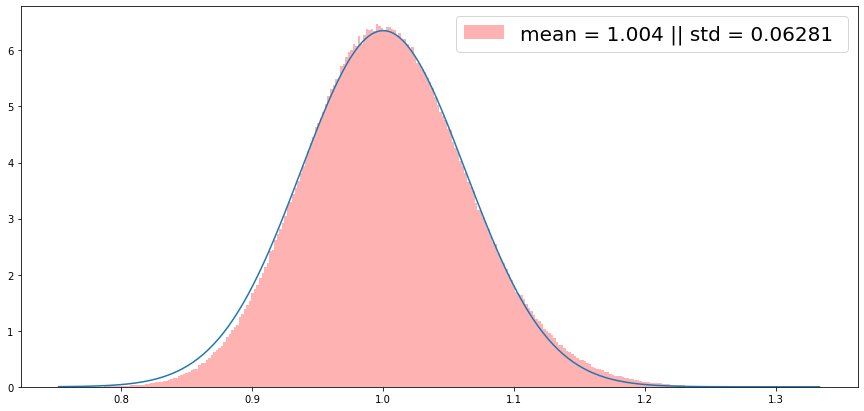

In [51]:

mmean = np.mean(QMC_hg[:,mmask]/all_QMC[:,mmask])


mstd  = np.std(QMC_hg[:,mmask]/all_QMC[:,mmask])
n,b,p = plt.hist((QMC_hg[:,mmask]/all_QMC[:,mmask]).flatten(),300,color = 'red',alpha=.3,\
             label= 'mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)

#plt.plot(b,scst.norm(1,1./all_QMC[:,mmask].mean()**.5).pdf(b))
plt.plot(b,scst.norm(1,mstd).pdf(b))

l = plt.gca().legend(prop={'size':20})


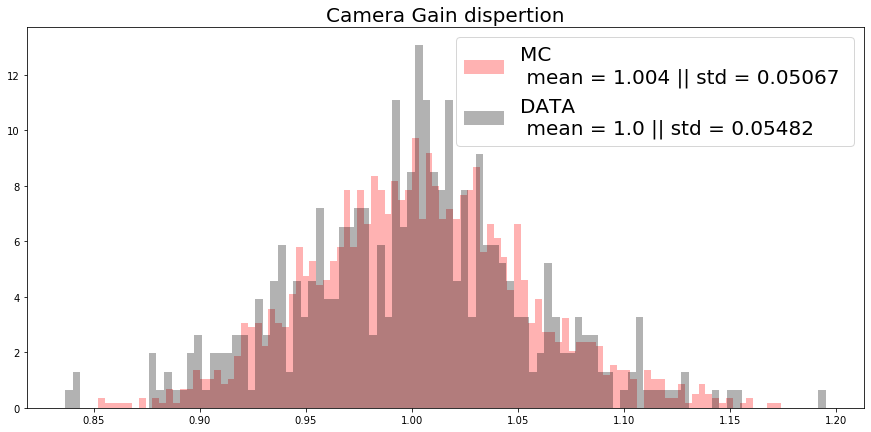

In [20]:

mmean = np.mean(Qs[mmask]/all_QMC.mean(axis=0)[mmask])
mstd  = np.std(Qs[mmask]/all_QMC.mean(axis=0)[mmask])
h = plt.hist(Qs[mmask]/all_QMC.mean(axis=0)[mmask],100,color = 'red',alpha=.3,\
             label= 'MC \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)

mmean = np.mean(Qs_data/Qs_data.mean())
mstd  = np.std(Qs_data/Qs_data.mean())
h = plt.hist(Qs_data/Qs_data.mean(),100,color = 'black',alpha=.3,\
             label= 'DATA \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)

l = plt.gca().legend(prop={'size':20})

l = plt.gca().set_title('Camera Gain dispertion',fontsize=20)

Text(0.5, 1.0, 'Charge resolution')

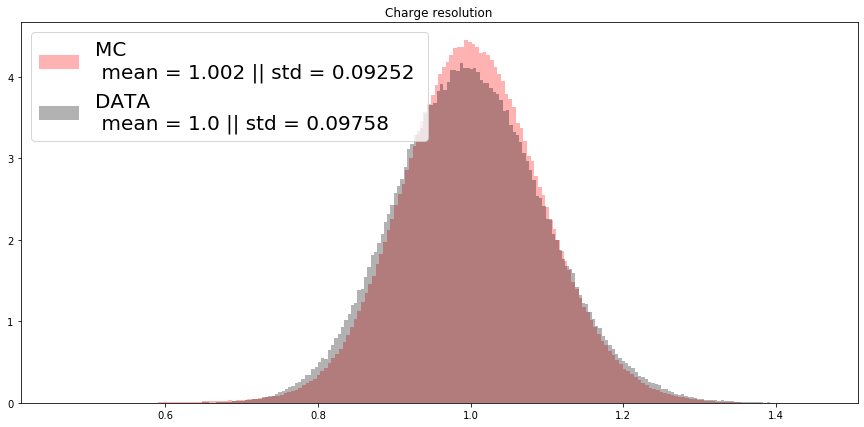

In [81]:

mmean = np.mean(QMC_hg[:,mmask]/all_QMC[:,mmask].mean())
mstd  = np.std(QMC_hg[:,mmask]/all_QMC[:,mmask].mean())

h = plt.hist((QMC_hg[:,mmask]/all_QMC[:,mmask].mean()).flatten(),200,color = 'red',alpha=.3,\
             label= 'MC \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)


mmean = np.mean(Qdata_hg/Qdata_hg.mean())
mstd  = np.std(Qdata_hg/Qdata_hg.mean())
n,b,p = plt.hist((Qdata_hg/Qdata_hg.mean()).flatten(),200,color = 'black',alpha=.3,\
             label= 'DATA \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)

l = plt.gca().legend(prop={'size':20})




plt.gca().set_title('Charge resolution')

Text(0.5, 1.0, 'Statistical pixel Charge resolution')

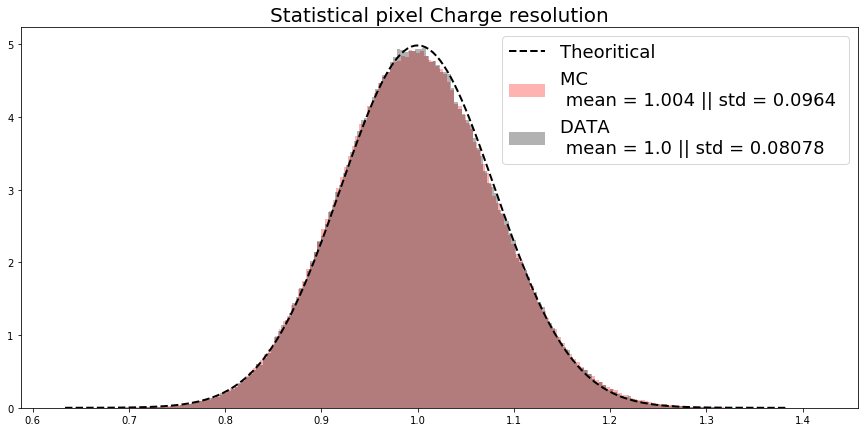

In [127]:

mmean = np.mean(QMC_hg[:,mmask]/all_QMC.mean(axis=0)[mmask])
mstd  = np.std(QMC_hg[:,mmask]/all_QMC.mean(axis=0)[mmask])

#n,b,p = plt.hist((QMC_hg[:,mmask]/all_QMC.mean(axis=0)[mmask]).flatten(),200,color = 'red',alpha=.3,\
#             label= 'MC \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)

h = plt.hist((QMC_hg[:,mmask]/QMC_hg[:,mmask].mean(axis=0)).flatten(),200,color = 'red',alpha=.3,\
             label= 'MC \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)

mmean = np.mean(Qdata_hg/Qdata_hg.mean(axis=0))
mstd  = np.std(Qdata_hg/Qdata_hg.mean(axis=0))
n,b,p = plt.hist((Qdata_hg/Qdata_hg.mean(axis=0)).flatten(),200,color = 'black',alpha=.3,\
             label= 'DATA \n mean = {:.4} || std = {:.4} '.format(mmean,mstd),density=1)

plt.plot(b,scst.norm(1,1.1/all_QMC[:,mmask].mean()**.5).pdf(b),'--',lw=2,color = 'black',label='Theoritical')

l = plt.gca().legend(prop={'size':18})
plt.gca().set_title('Statistical pixel Charge resolution',fontsize=20.)

Text(0.5, 1.0, 'High gain - low gain ratio')

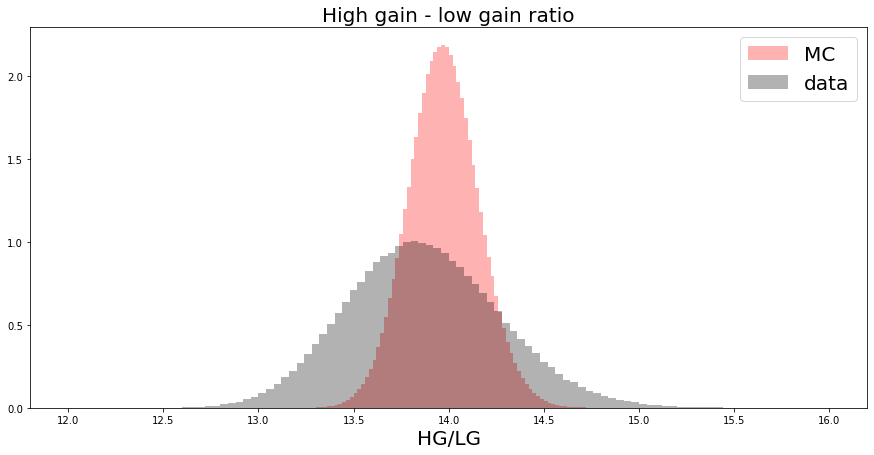

In [86]:
hh = plt.hist((QMC_hg[:,mmask]/QMC_lg[:,mmask]).flatten(),200,range=(12,16),color = 'red',alpha=.3,\
             label= 'MC',density=1)
hh = plt.hist((Qdata_hg/Qdata_lg).flatten(),100,range=(12,16),color = 'black',alpha=.3,\
             label= 'data',density=1)
l = plt.gca().legend(prop={'size':20})
plt.gca().set_xlabel('HG/LG',fontsize=20.)
plt.gca().set_title('High gain - low gain ratio',fontsize=20.)

0.012421814

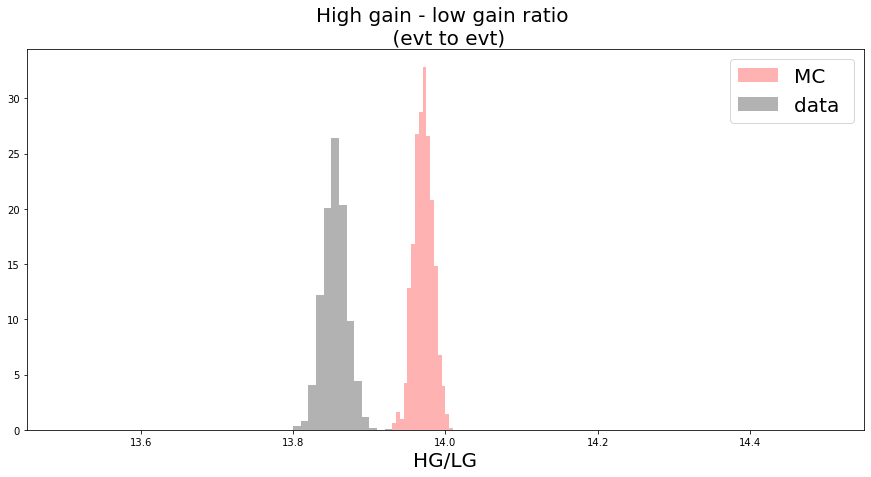

In [96]:
hh = plt.hist((QMC_hg[:,mmask].mean(axis=1)/QMC_lg[:,mmask].mean(axis=1)).flatten(),200,range=(13.5,14.5),color = 'red',alpha=.3,\
             label= 'MC',density=1)
hh = plt.hist((Qdata_hg.mean(axis=1)/Qdata_lg.mean(axis=1)).flatten(),100,range=(13.5,14.5),color = 'black',alpha=.3,\
             label= 'data ',density=1)
l = plt.gca().legend(prop={'size':20})
plt.gca().set_xlabel('HG/LG',fontsize=20.)
plt.gca().set_title('High gain - low gain ratio \n (evt to evt)',fontsize=20.)
(Qdata_hg.mean(axis=1)/Qdata_lg.mean(axis=1)).std() 
(QMC_hg[:,mmask].mean(axis=1)/QMC_lg[:,mmask].mean(axis=1)).std()

Text(0.5, 1.0, 'High gain - low gain ratio \n (pixel to pixel variation)')

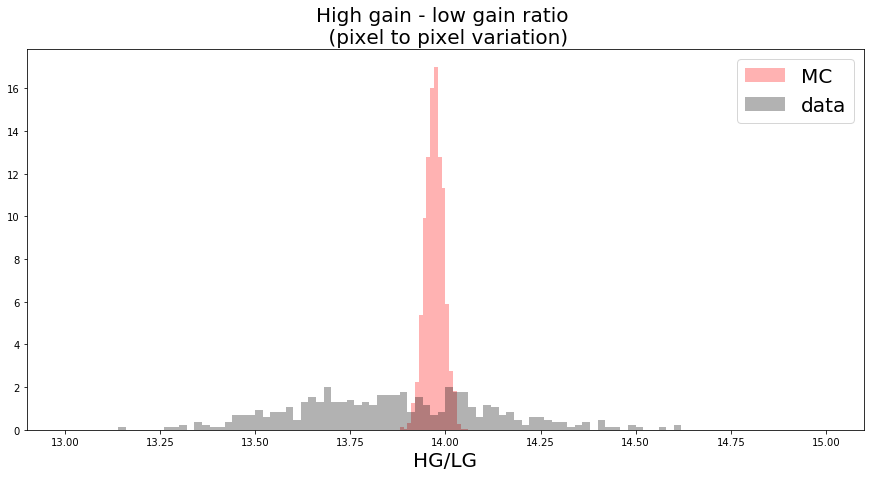

In [90]:
hh = plt.hist((QMC_hg[:,mmask].mean(axis=0)/QMC_lg[:,mmask].mean(axis=0)).flatten(),200,range=(13,15),color = 'red',alpha=.3,\
             label= 'MC',density=1)
hh = plt.hist((Qdata_hg.mean(axis=0)/Qdata_lg.mean(axis=0)).flatten(),100,range=(13,15),color = 'black',alpha=.3,\
             label= 'data',density=1)
l = plt.gca().legend(prop={'size':20})
plt.gca().set_xlabel('HG/LG',fontsize=20.)
plt.gca().set_title('High gain - low gain ratio \n (pixel to pixel variation)',fontsize=20.)

In [ ]:
QQQs.shape

0.08476684

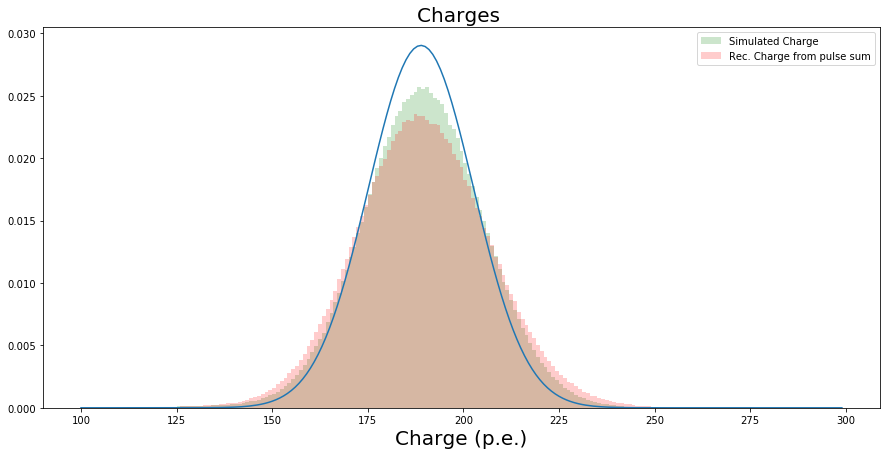

In [114]:
pix = 8
n,b,p= plt.hist(all_QMC[:,mmask].flatten(),bins=range(100,300,1),color='green',alpha=.2,\
           label= "Simulated Charge",density=1)

h= plt.hist(QMC_hg[:,mmask].flatten(),bins=range(100,300,1),color='red',alpha=.2,\
           label= "Rec. Charge from pulse sum",density=1)
#h= plt.hist((wfs_MC[:,0,:,:]-250.).max(axis=2).flatten()/14,bins=range(100,240,1),color='orange',alpha=.2,\
#           label= "Rec. Charge from pulse Amplitude",density=1)
mean = all_QMC[:,mmask].mean()

plt.plot(b,scst.norm(mean,mean**.5).pdf(b))

t = plt.gca().set_title('Charges ',fontsize=20.)
t = plt.gca().set_xlabel('Charge (p.e.)',fontsize=20.)
l = plt.gca().legend()


all_QMC[:,mmask].flatten().std()/all_QMC[:,mmask].mean()


Text(0.5, 1.0, 'Amplitude Vs Charge')

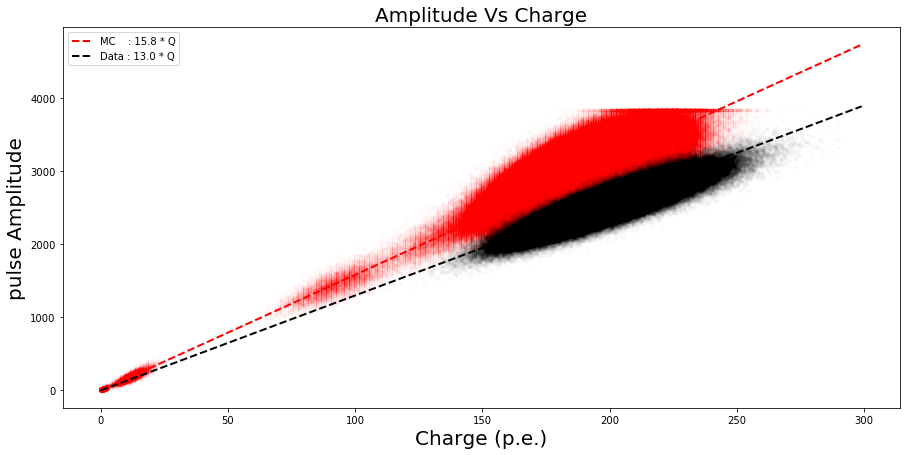

In [115]:
aa = all_QMC.flatten()
bb = (wfs_MC[:,0,:,:]-250.).max(axis=2).flatten()
mm = aa != 0

QA = (bb[mm]/aa[mm]).mean()

pp = plt.plot(all_QMC.flatten(),(wfs_MC[:,0,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'red')
pp = plt.plot(np.arange(300),np.arange(300)*QA,'--',color = 'red',\
              lw=2, label="MC    : {:.3} * Q".format(QA))

pp = plt.plot(Qdata_hg.flatten(),(wfs_data[:,0,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'black')


QAdat = ((wfs_data[:,0,:,:]-250.).max(axis=2).flatten()/((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten()).mean()

pp = plt.plot(np.arange(300),np.arange(300)*QAdat,'--',color = 'black',\
              lw=2, label="Data : {:.3} * Q".format(QAdat))

plt.gca().legend()
plt.gca().set_xlabel("Charge (p.e.)",fontsize=20.)
plt.gca().set_ylabel("pulse Amplitude",fontsize=20.)
plt.gca().set_title("Amplitude Vs Charge",fontsize=20.)

Text(0, 0.5, 'pulse Amplitude')

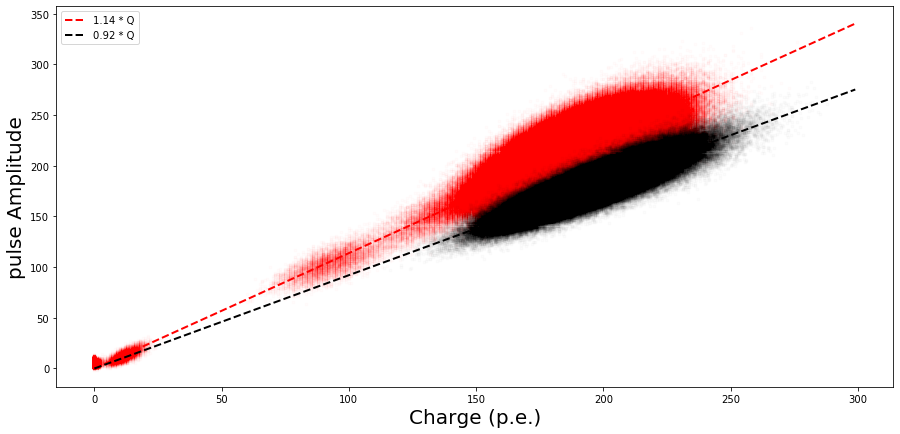

In [116]:
aa = all_QMC.flatten()
bb = (wfs_MC[:,1,:,:]-250.).max(axis=2).flatten()
mm = aa != 0

QA = (bb[mm]/aa[mm]).mean()

pp = plt.plot(all_QMC.flatten(),(wfs_MC[:,1,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'red')
pp = plt.plot(np.arange(300),np.arange(300)*QA,'--',color = 'red',\
              lw=2, label="{:.3} * Q".format(QA))

pp = plt.plot(((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten(),(wfs_data[:,1,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'black')


QAdat = ((wfs_data[:,1,:,:]-250.).max(axis=2).flatten()/((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten()).mean()

pp = plt.plot(np.arange(300),np.arange(300)*QAdat,'--',color = 'black',\
              lw=2, label="{:.3} * Q".format(QAdat))

plt.gca().legend()
plt.gca().set_xlabel("Charge (p.e.)",fontsize=20.)
plt.gca().set_ylabel("pulse Amplitude",fontsize=20.)

In [99]:
#from cta.MyNectar.scripts.Nectarpipe.MakePTemplate import * 
from MakePTemplate_aftp import GetSyncSpePulseShape_aftp

In [100]:
QAmp = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
pixs=[0,1]
pix=4
#fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape(wfs_data,500,4,0,pixs,ManualShift = 0,QAmp = 14.)

In [117]:
apt = []
sss = np.arange(0,60,.25)
for pix in range(10):
    pwfs = wfs_data[:,0,pix,:] - pedwfs[0,pix]
    fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape_aftp(pwfs,4,ManualShift = 0)
    apt.append(fct_dat(sss+np.mean(shft_dat))/len(wfs_data))

T_0 : 29.75 ns
shft 1.5231081328987244
Tstd ::  0.43444013637945805
T_0 : 29.75 ns
shft 1.5122527655230968
Tstd ::  0.4340650930627531
T_0 : 29.75 ns
shft 1.17790528529496
Tstd ::  0.34030014205217085
T_0 : 29.75 ns
shft 1.2925840241624955
Tstd ::  0.3918137718473861
T_0 : 29.75 ns
shft 1.155823636132987
Tstd ::  0.3470698170166249
T_0 : 29.75 ns
shft 1.3488089034670103
Tstd ::  0.40581253653175975
T_0 : 29.75 ns
shft 1.7252626795059351
Tstd ::  0.3976472429232734
T_0 : 29.75 ns
shft 2.167110399032457
Tstd ::  0.340141658778937
T_0 : 29.75 ns
shft 2.4451138891452064
Tstd ::  0.4287700617413898
T_0 : 29.75 ns
shft 1.876054124755392
Tstd ::  0.3356200046365329


In [ ]:
#pwfs = wfs_data[:,0,pix,:] - pedwfs[0,pix]
#fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape_aftp(pwfs,4,ManualShift = 0)

In [102]:
QAmp_MC = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
#fct_mc,tmax_mc,shft_mc,Tstd_mc = GetSyncSpePulseShape(wfs_MC,500,4,0,pixs,ManualShift = 0,QAmp = 14.)
fct_mc,tmax_mc,shft_mc,Tstd_mc = GetSyncSpePulseShape_aftp(wfs_MC[:,0,1,:]-250.,4,ManualShift = 0)

T_0 : 30.0 ns
shft 17.541379074301314
Tstd ::  0.4082099971918794


In [103]:
ff3 ="./PT25.dat"

f= open(ff3,'r')
sss3 =[]
p_template3=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss3.append(al[0])
        p_template3.append(al[1])
p_template3= np.array(p_template3)
Tar2  = np.arange(-1.,1+1/8.,1/8.)
ggg_TTS = stats.norm.pdf(Tar2,0,.64)
CPT_spe = np.convolve(p_template3,ggg_TTS,"same")/8.

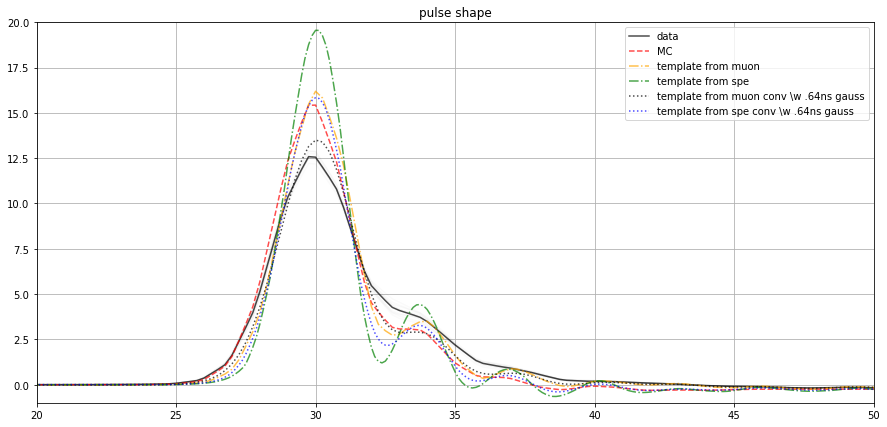

In [119]:
ff2 ="./Pulse_template_nectarCam_22112018.dat"

f= open(ff2,'r')
sss =[]
p_template=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss.append(al[0])
        p_template.append(al[1])

ff2 ="./PT8.dat"

f= open(ff2,'r')
sss2 =[]
p_template2=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss2.append(al[0])
        p_template2.append(al[1])

ff3 ="./PTSPE.dat"

f= open(ff3,'r')
sss3 =[]
p_template3=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:
        sss3.append(al[0])
        p_template3.append(al[1])
        

ss = np.arange(60)
apt=np.array(apt)
#plt.plot(sss,fct_dat(sss+np.mean(shft_dat))/len(wfs_data),':',color='black',label="data",alpha=.7)
plt.plot(np.arange(0,60,.25),apt.mean(axis=0),'-',color='black',label="data",alpha=.7)
plt.plot(np.arange(0,60,.25),apt.T,'-',color='black',alpha=.02)

plt.plot(sss,fct_mc(sss+np.mean(shft_mc))/len(wfs_MC),'--',color='red',label='MC',alpha=.7)
#plt.plot(np.array(sss),p_template,'-.',color='blue',label="old template",alpha=1.)
plt.plot(np.array(sss2),p_template2,'-.',color='orange',label="template from muon",alpha=.7)
plt.plot(np.array(sss3),p_template3,'-.',color='green',label="template from spe",alpha=.7)

Tar    = np.arange(-1,1.25,.25)
TTS_g  = stats.norm.pdf(Tar,0,.64)
CPT    = np.convolve(p_template2,TTS_g,"same")/4.

Tar2   = np.arange(-1,1+1/8. ,1/8.)
TTS_g2 = stats.norm.pdf(Tar2,0,.64)
CPT2   = np.convolve(p_template3,TTS_g2,"same")/8.

plt.plot(np.array(sss2),CPT ,':',color='black',label="template from muon conv \w .64ns gauss",alpha=.7)
plt.plot(np.array(sss3),CPT2,':',color='blue',label="template from spe conv \w .64ns gauss",alpha=.7)

l = plt.gca().legend()
plt.gca().set_title('pulse shape')
plt.gca().set_xlim(20,50)
plt.gca().set_ylim(-1,20)
plt.gca().grid()

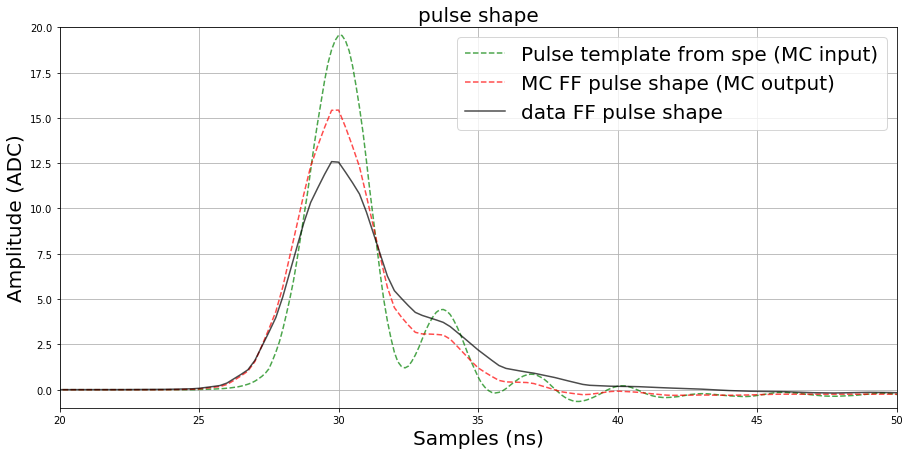

In [121]:


#plt.plot(np.array(sss),p_template,'-.',color='blue',label="old template",alpha=1.)
#plt.plot(np.array(sss2),p_template2,'--',color='orange',label="afterpulse shape (data)",alpha=.7)
plt.plot(np.array(sss3),p_template3,'--',color='green',label="Pulse template from spe (MC input)",alpha=.7)
plt.plot(sss,fct_mc(sss+np.mean(shft_mc))/len(wfs_MC),'--',color='red',label='MC FF pulse shape (MC output)',alpha=.7)
plt.plot(np.arange(0,60,.25),apt.mean(axis=0),'-',color='black',label="data FF pulse shape",alpha=.7)

l = plt.gca().legend(prop={'size':20})
plt.gca().set_title('pulse shape',fontsize=20)
plt.gca().set_xlim(20,50)
plt.gca().set_ylim(-1,20)

plt.gca().set_xlabel('Samples (ns)',fontsize=20)
plt.gca().set_ylabel('Amplitude (ADC)',fontsize=20)
plt.gca().grid()

In [ ]:
fct_mc(ss+np.mean(shft_mc))[20:40].max()/len(wfs_MC)


In [ ]:
fct_dat(ss+np.mean(shft_dat))[20:40].max()/len(wfs_data)

In [ ]:
fct_mc(ss+np.mean(shft_mc))[24:40].sum()/len(wfs_MC)

In [ ]:
fct_dat(ss+np.mean(shft_dat)).sum()/len(wfs_data)

In [ ]:
np.array(p_template2)[20*4:40*4:4].sum()

In [ ]:
np.array(p_template)[:].max()

In [ ]:
apt.mean(axis=0).max()